---
title: "Terse Alternating Least Squares Implementation"
pubDate: 2022-08-07T02:53:16+02:00
description: "Alternating Least Squares is a matrix factorization algorithm commonly used in recommendation systems. This notebook provides a practical explanation with code examples."
math: true
---

Recommendation systems are algorithms designed to suggest relevant items to users. They're behind many familiar features like Netflix movie recommendations or Amazon product suggestions.

One common approach is _collaborative filtering_, which uses the past behavior of many users to make recommendations. Matrix factorization methods like ALS are powerful techniques for collaborative filtering.

## The Matrix Factorization Problem

In recommendation systems, we typically have:

- A set of users
- A set of items
- A sparse matrix of known ratings or interactions

Let's call this sparse matrix $R$ where $R_{ui}$ represents user $u$'s rating for item $i$. Most entries in $R$ are unknown (missing).

The goal of matrix factorization is to approximate $R$ as the product of two lower-dimensional matrices:

$$ 
R \approx U \cdot V^T 
$$

Where:
$$
\begin{aligned}
& U \text{ is a user-feature matrix of shape } [\text{num\_users}, \text{num\_features}] \\
& V \text{ is an item-feature matrix of shape } [\text{num\_items}, \text{num\_features}]
\end{aligned}
$$


Each row of $U$ represents a user's latent feature vector, and each row of $V$ represents an item's latent feature vector.

### **Solving a Non-Convex Optimization Problem**

To reiterate, we aim to approximate $R$ using two lower-rank matrices, capturing the latent structure in the data:

$$
\min_{U, V} \sum_{(u,i) \in \text{observed}} (R_{ui} - U_u V_i^T)^2
$$

This is a **non-convex optimization problem** because both $ U $ and $ V $ are unknown and multiply each other. **Simultaneously** optimizing both matrices would require solving a problem with multiple local minima, making direct gradient-based optimization difficult.

### **Why ALS Works**
Instead of solving for both $ U $ and $ V $ at once, **Alternating Least Squares (ALS)** breaks the problem into two **convex subproblems**:

1. **Fix $ V $ and solve for $ U $**  
2. **Fix $ U $ and solve for $ V $**  

Since each of these steps is a standard **least squares problem**, they have a closed-form solution that can be computed efficiently.


## Setting Up Our Example

Let's create a small example with synthetic data to demonstrate ALS.

In [1]:
import numpy as np
np.set_printoptions(precision=3)
np.random.seed(42)

In [2]:
users = 50
items = 30
features = 10

The following matrix $R$ represents our sparse user-item interaction matrix. For simplicity, we're using binary values (0 or 1) to indicate whether a user interacted with an item:

In [3]:
R = np.random.choice([0, 1], size= [users,items], p=[.9, .1])
R

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(50, 30))

Here we initialize our user and item latent factor matrices with random values from a normal distribution. In a real application, we might use different initialization strategies:

In [4]:
U = np.random.normal(0,1, [users, features])
V = np.random.normal(0,1, [items, features])

### **Understanding the ALS Updates**

Matrix factorization assumes we approximate \( R \) using two lower-rank matrices \( U \) and \( V \):

$$
U V^T = R \quad \Leftrightarrow \quad V U^T = R^T
$$

From this, each row update follows:

- **For each row \( U[i] \):**  
  $$
  U[i] V = R[i]
  $$
  This corresponds to solving the least squares problem[^1]:

  $$
  U[i] = (V^T V)^{-1} V^T R[i]
  $$

- **For each row \( V[i] \):**  
  $$
  V[i] U = R[:, i]
  $$
  Which leads to the least squares update:

  $$
  V[i] = (U^T U)^{-1} U^T R[:, i]
  $$

Now, instead of iterating over rows, these updates can be **vectorized** for efficiency and conciseness:

- **Solving for \( U \) in matrix form:**
  $$
  U = R V (V^T V)^{-1}
  $$

- **Solving for \( V \) in matrix form:**
  $$
  V = R^T U (U^T U)^{-1}
  $$

In [5]:
# Compute initial reconstruction error
prev_score = np.linalg.norm(U @ V.T - R)

# Store errors for visualization
errors = [prev_score]

# ALS Iterations
num_iterations = 100
for iteration in range(num_iterations):
    # Without vectorization (per-row computation)
    # for i in range(U.shape[0]):
    #     U[i] = np.linalg.pinv(V.T @ V) @ V.T @ R[i]  

    # Equivalent vectorized form for solving U:
    # U = (np.linalg.pinv(V.T @ V) @ V.T @ R.T).T
    U = R @ V @ np.linalg.pinv(V.T @ V).T  # Efficient computation

    # Without vectorization (per-row computation)
    # for i in range(V.shape[0]):
    #     V[i] = np.linalg.pinv(U.T @ U) @ U.T @ R[:, i]

    # Equivalent vectorized form for solving V:
    # V = (np.linalg.pinv(U.T @ U) @ U.T @ R).T
    V = R.T @ U @ np.linalg.pinv(U.T @ U).T  # Efficient computation

    # Compute and store error after each iteration
    errors.append(np.linalg.norm(U @ V.T - R))

# Compute final reconstruction error
final_score = errors[-1]

print(f"Initial error: {errors[0]:.4f}")
print(f"Error after 1 iteration: {errors[1]:.4f}")
print(f"Final error after {num_iterations} iterations: {final_score:.4f}")

Initial error: 120.4196
Error after 1 iteration: 8.3655
Final error after 100 iterations: 6.6819


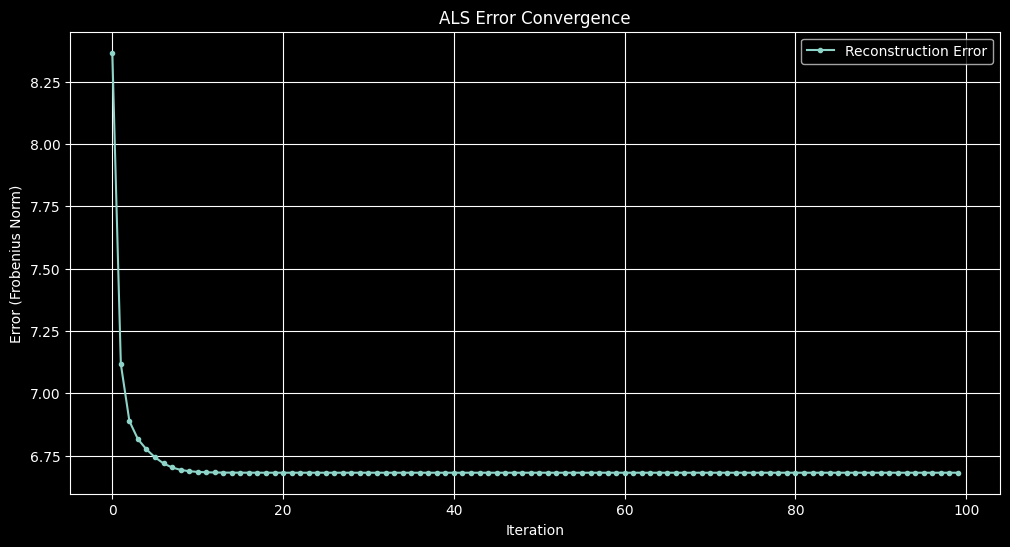

In [10]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
plt.plot(errors[1:], marker="o", linestyle="-", markersize=3, label="Reconstruction Error") # drop first error since it's a big drop that hides the convergence process
plt.xlabel("Iteration")
plt.ylabel("Error (Frobenius Norm)")
plt.title("ALS Error Convergence")
plt.legend()
plt.grid()
plt.show()


## Conclusion

Alternating Least Squares is a powerful technique for matrix factorization in recommendation systems. The algorithm's key advantage is that it handles the non-convex optimization problem by alternating between convex subproblems, each of which has a closed-form solution.

While more advanced techniques like neural collaborative filtering have emerged in recent years, ALS remains relevant for its simplicity, interpretability, and effectiveness, especially for large-scale recommendation tasks.

### **Additional Considerations**
While this implementation presents the core idea of ALS, in practice, a few important modifications are often made:

- **Regularization**: To prevent overfitting and improve numerical stability, regularization terms are often added to the update equations:
  
    $$
    U = (V^T V + \lambda I)^{-1} V^T R
    \quad \text{and} \quad
    V = (U^T U + \lambda I)^{-1} U^T R
    $$

  This helps when the dataset is sparse and avoids **singular matrix issues** in the inversion step.

- **Alternatives to ALS**: Another common approach to matrix factorization is **Stochastic Gradient Descent (SGD)**, which iteratively updates each parameter using gradient-based optimization. Unlike ALS, which updates full rows at once, **SGD optimizes individual elements** â€” making it more suitable for **online learning** but slower for large datasets.

These modifications and alternative approaches are worth exploring when adapting ALS to real-world scenarios.

## References:
[^1]: https://mathworld.wolfram.com/NormalEquation.html
